---
syncID: 9a1e6798f2e94a71bbcd1c6a1f5946d2
title: "Classification of Hyperspectral Data with Principal Components Analysis (PCA) in Python"
description: "Learn to classify spectral data using the Principal Components Analysis (PCA) method."
dateCreated: 2017-06-21 
authors: Paul Gader
contributors:
estimatedTime:
packagesLibraries: numpy, gdal, matplotlib, matplotlib.pyplot
topics: hyperspectral-remote-sensing, HDF5, remote-sensing
languagesTool: python
dataProduct: NEON.DP1.30006, NEON.DP3.30006, NEON.DP1.30008
code1: Python/remote-sensing/hyperspectral-data/Classification_PCA.ipynb
tutorialSeries: intro-hsi-py-series
urlTitle: classification-pca-python
---

Load Some Spectra

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import io
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def PlotSpectraAndMean(Spectra, Wv, fignum):
    ### Spectra is NBands x NSamps
    mu = np.mean(Spectra, axis=1)
    print(np.shape(mu))
    plt.figure(fignum)
    plt.plot(Wv, Spectra, 'c')
    plt.plot(Wv, mu, 'r')
    plt.show()
    return mu

Load Some Spectra

In [3]:
filename   = 'OSBSTinyIm.mat'
ImDict     = io.loadmat(filename)
OSBSTinyIm = ImDict['OSBSTinyIm']
TinySize   = np.shape(OSBSTinyIm)
NRows      = TinySize[0]
NCols      = TinySize[1]
NBands     = TinySize[2]
print('{0:4d} {1:4d} {2:4d}'.format(NRows, NCols, NBands))

  62  194  346


GET SOME WAVELENGTHS

(346, 1)


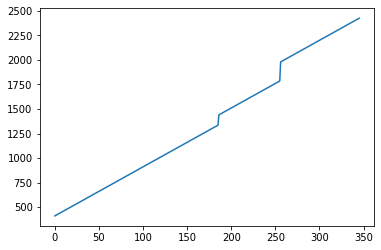

In [4]:
### LOAD WAVELENGTHS WITH WATER BANDS ###
### AND BAD BEGINNING AND ENDING BANDS REMOVED ###
Wv = io.loadmat("NEONWvsNBB")
Wv = Wv['NEONWvsNBB']
print(np.shape(Wv))

plt.figure(1)
plt.plot(range(346), Wv)
plt.show()

Let's load indices for Red, Green, and Blue for NEON hyperspectral data

In [5]:
### HAVE TO SUBTRACT AN OFFSET BECAUSE OF BAD BAND ###
### REMOVAL AND 0-BASED Python vs 1-Based MATLAB   ###
Offset     = 7

### LOAD & PRINT THE INDICES FOR THE COLORS   ###
### AND DIG THEM OUT OF MANY LAYERS OF ARRAYS ###
NEONColors = io.loadmat('NEONColors.mat')
NEONRed    = NEONColors['NEONRed']
NEONGreen  = NEONColors['NEONGreen']
NEONBlue   = NEONColors['NEONBlue']
NEONNir    = NEONColors['NEONNir']
NEONRed    = NEONRed[0][0]-Offset
NEONGreen  = NEONGreen[0][0]-Offset
NEONBlue   = NEONBlue[0][0]-Offset
NEONNir    = NEONNir[0][0]-Offset
print('Indices:     {0:4d} {1:4d} {2:4d} {3:4d}'.format(NEONRed, NEONGreen, NEONBlue, NEONNir))

### CONVERT THE INDICES TO WAVELENGTHS ###
NEONRedWv    = Wv[NEONRed][0]
NEONGreenWv  = Wv[NEONGreen][0]
NEONBlueWv   = Wv[NEONBlue][0]
NEONNirWv    = Wv[NEONNir][0]
print('Wavelengths: {0:4d} {1:4d} {2:4d} {3:4d}'.format(NEONRedWv, NEONGreenWv, NEONBlueWv, NEONNirWv))

Indices:       47   25    6  119
Wavelengths:  645  535  440 1005


Now we can make a color image and display it

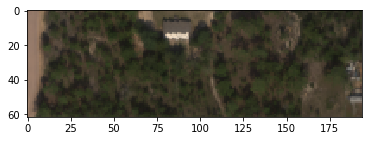

In [6]:
RGBIm = OSBSTinyIm[:, :, [NEONRed, NEONGreen, NEONBlue]]
RGBIm = np.sqrt(RGBIm)
plt.figure(2)
plt.imshow(RGBIm)
plt.show()

Now let's turn the image into a sequence of vectors
so we can use matrix algebra

In [7]:
### HAVE TO TAKE INTO ACCOUNT DIFFERENCES BETWEEN Python AND Matlab ###
### Python USES THE    C     PROGRAMMING LANGUAGE ORDERING ###
### MATLAB USERS THE FORTRAN PROGRAMMING LANGUAGE ORDERING ###
### Python WOULD RESHAPE BY REFERENCE AND MATLAB BY VALUE  ###
### THEREFORE, WE NEED TO COPY THE VALUES EXPLICITLY       ###
TinyVecs = OSBSTinyIm.reshape(NRows*NCols, NBands, order='F').copy()

### MATLAB TREATS THE ROWS AS DATA SAMPLES ###
### np  TREATS THE COLS AS DATA SAMPLES ###
TinyVecs = np.transpose(TinyVecs)
NSamps   = np.shape(TinyVecs)[1]
np.shape(TinyVecs)

(346, 12028)

(346,)


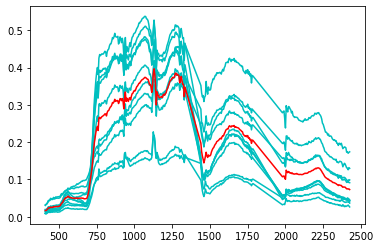

In [8]:
### EXERCISE
SpecIndices = range(1000, 2000, 100)
SomeSpectra = TinyVecs[:, range(1000, 2000, 100)]
mymu        = PlotSpectraAndMean(SomeSpectra, Wv, 3)

In [9]:
np.shape(mymu)

(346,)

Let's plot some spectra

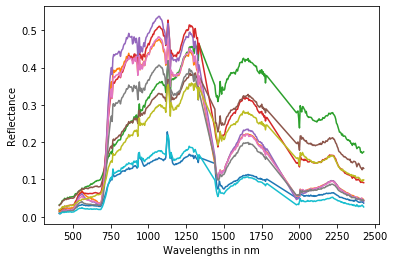

In [10]:
### Indices of Spectra to Try ###
### SpecIndices = range(0, 1000, 100) ###
SpecIndices = range(1000, 2000, 100)
SomeSpectra = TinyVecs[:, range(1000, 2000, 100)]
plt.figure(3)
plt.plot(Wv, SomeSpectra)
plt.xlabel('Wavelengths in nm')
plt.ylabel('Reflectance')
plt.show()

Compute the Average Spectrum and plot it


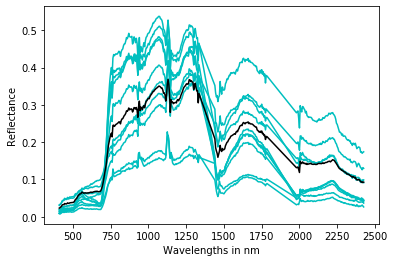

In [11]:
mu = np.mean(TinyVecs, axis=1)
plt.figure(4)
plt.plot(Wv, SomeSpectra, 'c')
plt.plot(Wv, mu, 'k')
plt.xlabel('Wavelengths in nm')
plt.ylabel('Reflectance')
plt.show()

Now we want to subtract the mean from every sample

In [12]:
np.shape(mu)

(346,)

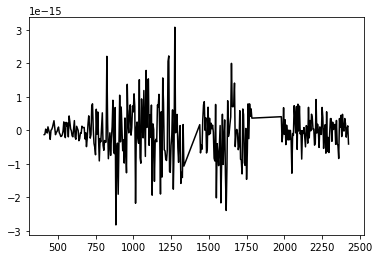

In [13]:
TinyVecsZ = np.zeros((NBands, NSamps))
for n in range(NSamps):
    TinyVecsZ[range(NBands),n]= TinyVecs[(range(NBands), n)]-mu

muz = np.mean(TinyVecsZ, axis=1)
plt.figure(5)
plt.plot(Wv, muz, 'k')
#plt.ylim(-1,1)
plt.show()

Let's make the covariance

In [14]:
C = np.cov(TinyVecs)
np.shape(C)

(346, 346)

We can look at some of the values but too many to look at them all.
We can also view C as an image

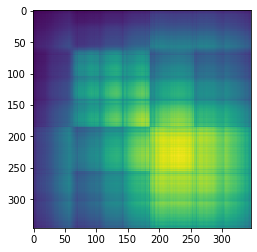

In [15]:
plt.figure(6)
plt.imshow(C)
plt.show()

In [16]:
# PRINT OUT SOME "AMPLIFIED" COVARIANCE VALUES %%%
for cn in range(0, 50,5):
    w = int(Wv[cn])
    if cn==0:
        print("     ", end=" ")
    else:
        print('{0:5d}'.format(w), end=" ")
print('\n')


for rn in range(5, 50, 5):
    w = int(Wv[rn])
    print('{0:5d}'.format(w), end=" ")
    for cn in range(5,50,5):
        CovVal = int(100000*C[rn, rn])
        print('{0:5d}'.format(CovVal), end=" ")
    print('\n')
    
#print(round(100000*C[NEONBlue, NEONNir]))
#print(round(100000*C[NEONGreen, NEONNir]))
#print(round(100000*C[NEONRed, NEONNir]))
#print(round(100000*C[NEONGreen, NEONRed]))

        435   460   485   510   535   560   585   610   635 

  435   166   166   166   166   166   166   166   166   166 

  460   198   198   198   198   198   198   198   198   198 

  485   226   226   226   226   226   226   226   226   226 

  510   245   245   245   245   245   245   245   245   245 

  535   289   289   289   289   289   289   289   289   289 

  560   360   360   360   360   360   360   360   360   360 

  585   428   428   428   428   428   428   428   428   428 

  610   479   479   479   479   479   479   479   479   479 

  635   544   544   544   544   544   544   544   544   544 



Notice that there are no negative values.  Why?

What if we normalize the vectors to have Norm 1 (common strategy)

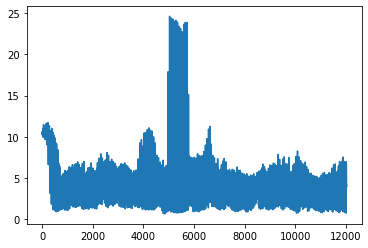

In [17]:
Norms = np.sqrt(np.sum(TinyVecs*TinyVecs, axis=0))
plt.figure(7)
plt.plot(Norms)
### Too many Norms.  How do we fix?
plt.show()

In [18]:
np.shape(Norms)

(12028,)

In [19]:
np.shape(TinyVecs)

(346, 12028)

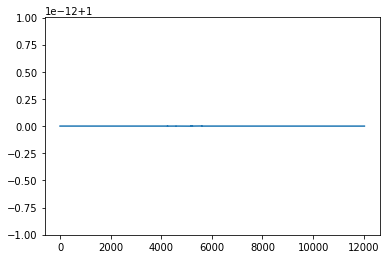

1.000000 1.000000


In [20]:
### Allocate Memory
TinyVecsNorm = np.zeros((NBands, NSamps))
for samp in range(NSamps):
    NormSamp = Norms[samp]
    for band in range(NBands):
        TinyVecsNorm[band, samp] = TinyVecs[band,samp]/NormSamp
        
Norms1 = np.sqrt(np.sum(TinyVecsNorm*TinyVecsNorm, axis=0))
plt.figure(7)
plt.plot(Norms1)
plt.show()
BigNorm = np.max(Norms1)
LitNorm = np.min(Norms1)
print('{0:4f} {1:4f}'.format(BigNorm, LitNorm))
### Too many Norms.  How do we fix?

Exercise:  Turn the script for plotting spectra and their mean above into a function

(346,)


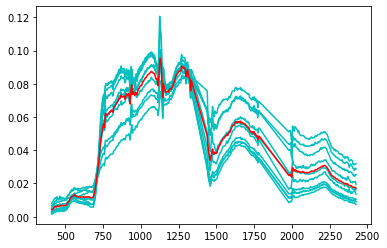

In [21]:
### EXERCISE
SpecIndices     = range(1000, 2000, 100)
SomeSpectraNorm = TinyVecsNorm[:, range(1000, 2000, 100)]
MuNorm          = PlotSpectraAndMean(SomeSpectraNorm, Wv, 3)

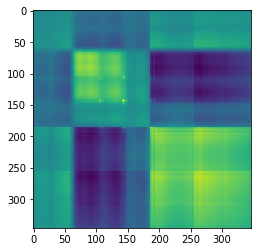

In [22]:
CNorm = np.cov(TinyVecsNorm)
plt.figure()
plt.imshow(CNorm)
plt.show()

In [23]:
# PRINT OUT SOME "AMPLIFIED" COVARIANCE VALUES %%%
for cn in range(0, 50,5):
    w = int(Wv[cn])
    if cn==0:
        print("     ", end=" ")
    else:
        print('{0:5d}'.format(w), end=" ")
print('\n')


for rn in range(5, 50, 5):
    w = int(Wv[rn])
    print('{0:5d}'.format(w), end=" ")
    for cn in range(5,50,5):
        CovVal = int(10000000*CNorm[rn, rn])
        print('{0:5d}'.format(CovVal), end=" ")
    print('\n')

        435   460   485   510   535   560   585   610   635 

  435   253   253   253   253   253   253   253   253   253 

  460   269   269   269   269   269   269   269   269   269 

  485   289   289   289   289   289   289   289   289   289 

  510   284   284   284   284   284   284   284   284   284 

  535   263   263   263   263   263   263   263   263   263 

  560   303   303   303   303   303   303   303   303   303 

  585   397   397   397   397   397   397   397   397   397 

  610   455   455   455   455   455   455   455   455   455 

  635   523   523   523   523   523   523   523   523   523 



In [24]:
print(np.shape(TinyVecs))
print(NEONNir)
print(NEONRed)
NIRVals  = TinyVecs[NEONNir, range(NSamps)]
RedVals  = TinyVecs[NEONRed, range(NSamps)]
NDVIVals = (NIRVals-RedVals)/(NIRVals+RedVals)
np.shape(NDVIVals)
NDVIIm   = np.reshape(NDVIVals,(NRows, NCols),order='F')

(346, 12028)
119
47


In [25]:
print(np.shape(NDVIIm))

(62, 194)


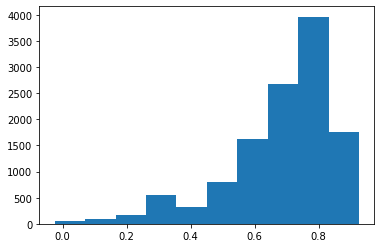

In [26]:
plt.figure()
plt.hist(NDVIVals)
plt.show()

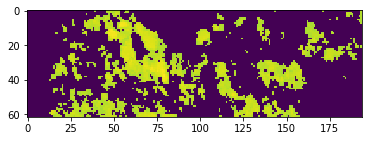

In [27]:
HiNDVI = NDVIIm*(NDVIIm>0.8)
plt.figure()
plt.imshow(HiNDVI)
plt.show()

In [28]:
# plt.figure()
# plt.plot(nonzero(NDVIVals>0.8))
# plt.show()
VegIndices = np.nonzero(NDVIVals>0.8)
# print(VegIndices[0])
print(np.shape(VegIndices))
# print(np.shape(TinyVecs))
VegSpectra = TinyVecs[:, VegIndices[0]]
print(np.shape(VegSpectra))

(1, 3136)
(346, 3136)


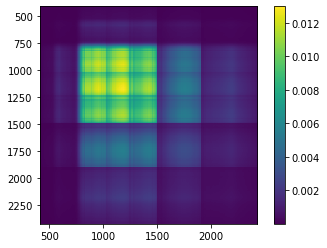

In [29]:
CVeg = np.cov(VegSpectra)
plt.figure(9)
plt.imshow?
plt.imshow(CVeg,extent=(np.amin(Wv), np.amax(Wv),np.amax(Wv), np.amin(Wv)))
plt.colorbar()
plt.show()

OK, Let's do PCA

Recall that TinyVecsZ is the mean-subtracted version of the original spectra 

In [30]:
C   = np.cov(TinyVecs)
D,V = linalg.eig(C)
D   = D.real
print(np.shape(D))
print(np.shape(V))
print(TinyVecs.shape)
print(V[0,0])

(346,)
(346, 346)
(346, 12028)
-0.01248229145732032


(346,)
(346,)


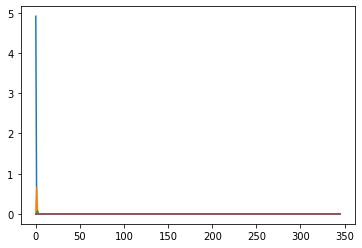

In [31]:
plt.figure(10)
print(D.shape)
DiagD = np.diag(D)
print(D.shape)
plt.plot(DiagD)
#Exercise
#plt.plot(D[range(10)])
#plt.plot(D[range(10, 30, 10)])
plt.show()

In [32]:
TinyVecsPCA = np.dot(V.T, TinyVecs)
PCACovar    = np.cov(TinyVecsPCA)
D,V         = linalg.eig(C)
D           = D.real
print(D.shape)
print(PCACovar.shape)
for r in range(10):
    print('{0:5f} {1:5f}'.format(D[r], PCACovar[r,r]))
print()
for r in range(10):
    for c in range(10):
        NextVal = int(10000*PCACovar[r,c])
        print('{0:5d}'.format(NextVal), end=" ")
    print('\n')
# #Delta       = np.sum(np.sum((PCACovar-D), axis=0), axis=0)
# print(Delta)
# plt.figure(11)
# plt.plot(np.diag(PCACovar))
# plt.show()

(346,)
(346, 346)
4.911250 4.911250
0.653442 0.653442
0.083168 0.083168
0.013260 0.013260
0.004038 0.004038
0.003201 0.003201
0.001390 0.001390
0.000931 0.000931
0.000705 0.000705
0.000561 0.000561

49112     0     0     0     0     0     0     0     0     0 

    0  6534     0     0     0     0     0     0     0     0 

    0     0   831     0     0     0     0     0     0     0 

    0     0     0   132     0     0     0     0     0     0 

    0     0     0     0    40     0     0     0     0     0 

    0     0     0     0     0    32     0     0     0     0 

    0     0     0     0     0     0    13     0     0     0 

    0     0     0     0     0     0     0     9     0     0 

    0     0     0     0     0     0     0     0     7     0 

    0     0     0     0     0     0     0     0     0     5 



Notice that the values on the diagonal are the variances of each coordinate in the PCA transformed data.  They drop off rapidly which is why one can reduce dimensionality by discarding components that have low variance.  Also, notice that the diagonal matrix D produce by diagonalizing the covariance of x is the covariance of y = PCA(x).

If the data are Gaussian, then the coordinates of y are uncorrelated and independent.  If not, then only uncorrelated.

Let's pull out the first 3 dimensions and plot them'

<IPython.core.display.Javascript object>


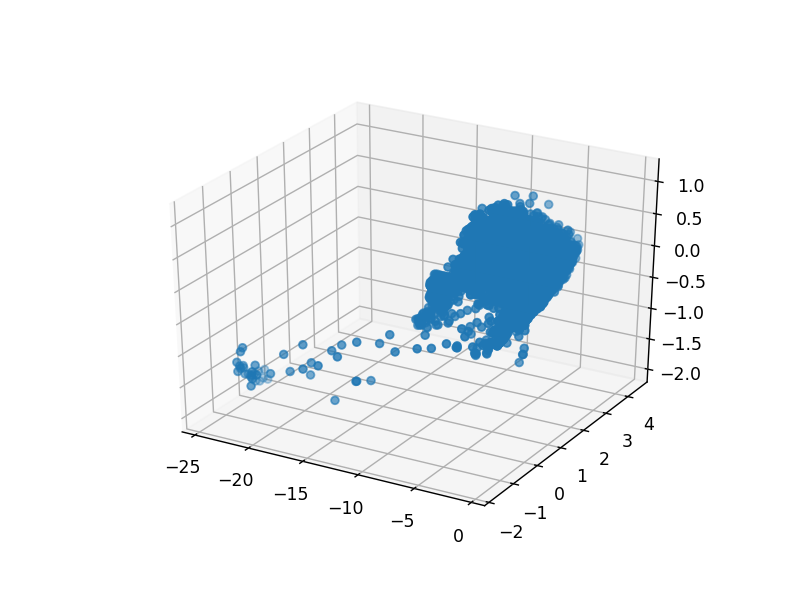

In [33]:
%matplotlib notebook
fig = plt.figure(13)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(TinyVecsPCA[0,range(NSamps)],TinyVecsPCA[1,range(NSamps)],TinyVecsPCA[2,range(NSamps)], marker='o')
plt.show()

We can also display principal components as images

<IPython.core.display.Javascript object>


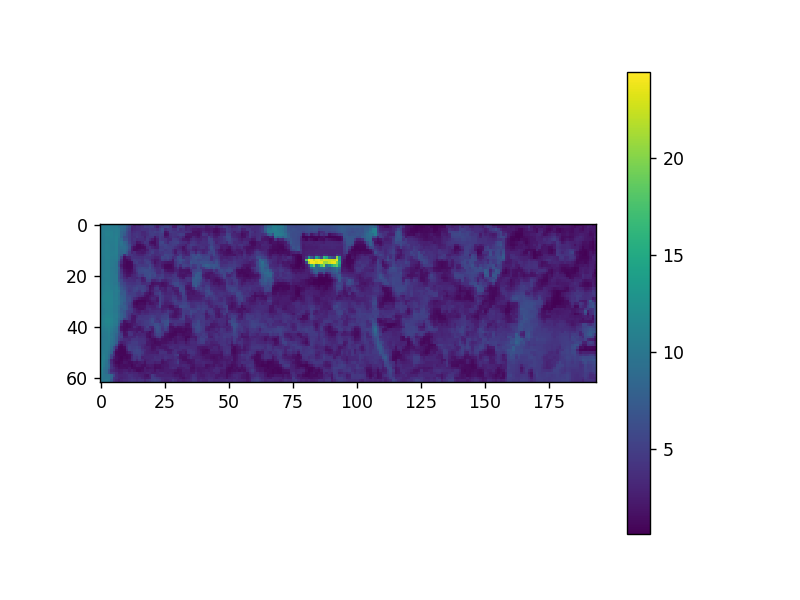

<IPython.core.display.Javascript object>


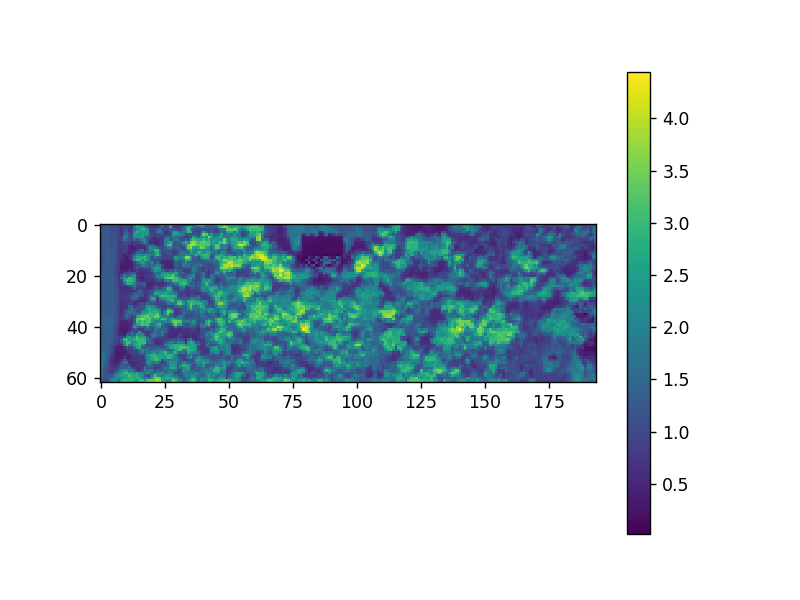

<IPython.core.display.Javascript object>


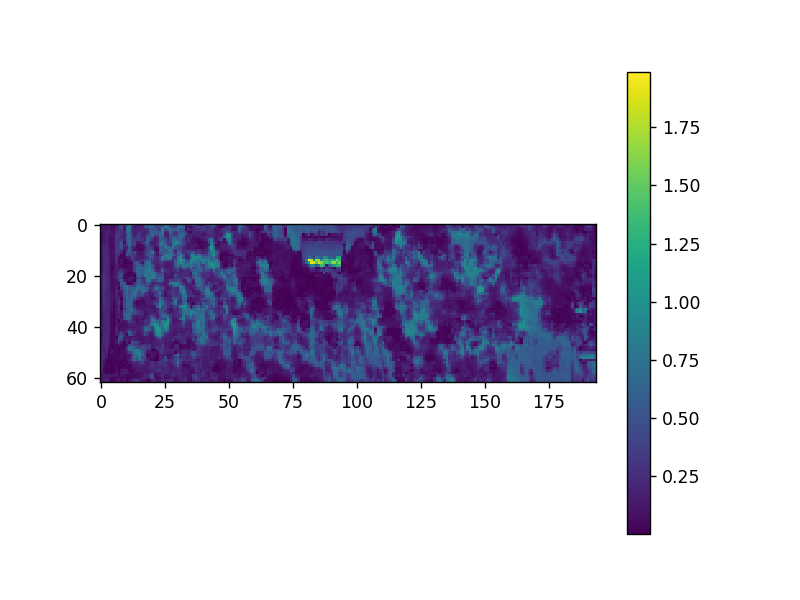

In [34]:
for coord in range(3):
    P1 = TinyVecsPCA[coord, :]
    PCAIm      = np.reshape(P1, (NRows, NCols), order='F')
    plt.figure(14+coord)
    plt.imshow(np.abs(PCAIm))
    plt.colorbar()
    plt.show()

#EXERCISE:  Write a function that calculates PCA of spectra and plots the first 3 components